# Colorize Black white Image

This Deep Learning Project aims to provide colorizing black & white images with Python.

In image colorization, we take a black and white image as input and produce a colored image. We will solve this project with OpenCV deep neural network.

<img src="Animation.gif" />

### Lab Color Space:

Like RGB, Lab is another color space. It is also three channel color space like RGB where the channels are:

    L channel: This channel represents the Lightness
    a channel: This channel represents green-red
    b channel: This channel represents blue-yellow

In this color space, the grayscale part of the image is only encoded in L channel. Therefore Lab color space is more favorable for our project.

### Problem Statement:

deep learning project colorize black white images with python

We can formulate our problem statement as to predict a and b channels, given an input grayscale image.

In this deep learning project, we will use OpenCV DNN architecture which is trained on ImageNet dataset. The neural net is trained with the L channel of images as input data and a,b channels as target data.

#### Steps to implement Image Colorization Project:

For colorizing black and white images we will be using a pre-trained caffe model, a prototxt file, and a NumPy file.

The prototxt file defines the network and the numpy file stores the cluster center points in numpy format.

1. Make a directory with name models.

In [1]:
!mkdir models

A subdirectory or file models already exists.


download the caffemodel, prototxt file and the NumPy file.

In [2]:
!wget https://github.com/richzhang/colorization/blob/caffe/colorization/resources/pts_in_hull.npy?raw=true -O ./pts_in_hull.npy


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
!wget https://raw.githubusercontent.com/richzhang/colorization/caffe/colorization/models/colorization_deploy_v2.prototxt -O ./models/colorization_deploy_v2.prototxt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!wget http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel -O ./models/colorization_release_v2.caffemodel


'wget' is not recognized as an internal or external command,
operable program or batch file.


### Import Essential Library

In [5]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os.path

### Read B&W image and load the caffemodel:

In [7]:
frame = cv.imread("new.jpg")

numpy_file = np.load('./pts_in_hull.npy')
Caffe_net = cv.dnn.readNetFromCaffe("./models/colorization_deploy_v2.prototxt", "./models/colorization_release_v2.caffemodel")



rgb_img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)		# this converts it into RGB
plt.imshow(rgb_img)
plt.show()


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\dnn\src\caffe\caffe_io.cpp:1138: error: (-2:Unspecified error) FAILED: fs.is_open(). Can't open "./models/colorization_release_v2.caffemodel" in function 'cv::dnn::ReadProtoFromBinaryFile'


### Add layers to the caffe model:

In [ ]:
numpy_file = numpy_file.transpose().reshape(2, 313, 1, 1)
Caffe_net.getLayer(Caffe_net.getLayerId('class8_ab')).blobs = [numpy_file.astype(np.float32)]
Caffe_net.getLayer(Caffe_net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, np.float32)]

### Extract L channel and resize it:

In [ ]:
input_width = 224
input_height = 224

rgb_img = (frame[:,:,[2, 1, 0]] * 1.0 / 255).astype(np.float32)
lab_img = cv.cvtColor(rgb_img, cv.COLOR_RGB2Lab)
l_channel = lab_img[:,:,0] 

l_channel_resize = cv.resize(l_channel, (input_width, input_height)) 
l_channel_resize -= 50

### Predict the ab channel and save the result:

In [ ]:
Caffe_net.setInput(cv.dnn.blobFromImage(l_channel_resize))
ab_channel = Caffe_net.forward()[0,:,:,:].transpose((1,2,0)) 

(original_height,original_width) = rgb_img.shape[:2] 
ab_channel_us = cv.resize(ab_channel, (original_width, original_height))
lab_output = np.concatenate((l_channel[:,:,np.newaxis],ab_channel_us),axis=2) 
bgr_output = np.clip(cv.cvtColor(lab_output, cv.COLOR_Lab2BGR), 0, 1)

cv.imwrite("./result.png", (bgr_output*255).astype(np.uint8))

True

### Output


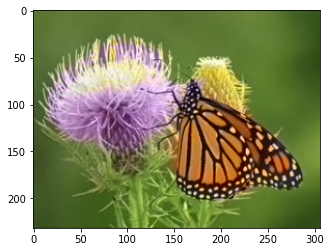

In [ ]:
frame1 = cv.imread("result.png")
rgb_img = cv.cvtColor(frame1, cv.COLOR_BGR2RGB)		# this converts it into RGB
plt.imshow(rgb_img)
plt.show()


## Code for GUI:

In [ ]:
%%writefile gui.py

import tkinter as tk
from tkinter import *
from tkinter import filedialog
from PIL import Image, ImageTk
import os
import numpy as np
import cv2 as cv
import os.path
import matplotlib
matplotlib.use('Agg')

import sys
import os

if os.environ.get('DISPLAY','') == '':
    print('no display found. Using :0.0')
    os.environ.__setitem__('DISPLAY', ':0.0')
    
numpy_file = np.load('./pts_in_hull.npy')
Caffe_net = cv.dnn.readNetFromCaffe("./models/colorization_deploy_v2.prototxt", "./models/colorization_release_v2.caffemodel")
numpy_file = numpy_file.transpose().reshape(2, 313, 1, 1)

class Window(Frame):
    def __init__(self, master=None):
        Frame.__init__(self, master)

        self.master = master
        self.pos = []
        self.master.title("B&W Image Colorization")
        self.pack(fill=BOTH, expand=1)

        menu = Menu(self.master)
        self.master.config(menu=menu)

        file = Menu(menu)
        file.add_command(label="Upload Image", command=self.uploadImage)
        file.add_command(label="Color Image", command=self.color)
        menu.add_cascade(label="File", menu=file)

        self.canvas = tk.Canvas(self)
        self.canvas.pack(fill=tk.BOTH, expand=True)
        self.image = None
        self.image2 = None

        label1=Label(self,image=img)
        label1.image=img
        label1.place(x=400,y=370)




    def uploadImage(self):
        filename = filedialog.askopenfilename(initialdir=os.getcwd())
        if not filename:
            return
        load = Image.open(filename)

        load = load.resize((480, 360), Image.ANTIALIAS)

        if self.image is None:
            w, h = load.size
            width, height = root.winfo_width(), root.winfo_height()
            self.render = ImageTk.PhotoImage(load)
            self.image = self.canvas.create_image((w / 2, h / 2), image=self.render)
           
        else:
            self.canvas.delete(self.image3)
            w, h = load.size
            width, height = root.winfo_screenmmwidth(), root.winfo_screenheight()
           
            self.render2 = ImageTk.PhotoImage(load)
            self.image2 = self.canvas.create_image((w / 2, h / 2), image=self.render2)


        frame = cv.imread(filename)
    
        Caffe_net.getLayer(Caffe_net.getLayerId('class8_ab')).blobs = [numpy_file.astype(np.float32)]
        Caffe_net.getLayer(Caffe_net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, np.float32)]

        input_width = 224
        input_height = 224

        rgb_img = (frame[:,:,[2, 1, 0]] * 1.0 / 255).astype(np.float32)
        lab_img = cv.cvtColor(rgb_img, cv.COLOR_RGB2Lab)
        l_channel = lab_img[:,:,0] 

        l_channel_resize = cv.resize(l_channel, (input_width, input_height)) 
        l_channel_resize -= 50 

        Caffe_net.setInput(cv.dnn.blobFromImage(l_channel_resize))
        ab_channel = Caffe_net.forward()[0,:,:,:].transpose((1,2,0)) 

        (original_height,original_width) = rgb_img.shape[:2] 
        ab_channel_us = cv.resize(ab_channel, (original_width, original_height))
        lab_output = np.concatenate((l_channel[:,:,np.newaxis],ab_channel_us),axis=2) 
        bgr_output = np.clip(cv.cvtColor(lab_output, cv.COLOR_Lab2BGR), 0, 1)

  
        cv.imwrite("./result.png", (bgr_output*255).astype(np.uint8))

    def color(self):

        load = Image.open("./result.png")
        load = load.resize((480, 360), Image.ANTIALIAS)

        if self.image is None:
            w, h = load.size
            self.render = ImageTk.PhotoImage(load)
            self.image = self.canvas.create_image((w / 2, h/2), image=self.render)
            root.geometry("%dx%d" % (w, h))
        else:
            w, h = load.size
            width, height = root.winfo_screenmmwidth(), root.winfo_screenheight()

            self.render3 = ImageTk.PhotoImage(load)
            self.image3 = self.canvas.create_image((w / 2, h / 2), image=self.render3)
            self.canvas.move(self.image3, 500, 0)
 

root = tk.Tk()
root.geometry("%dx%d" % (980, 600))
root.title("B&W Image Colorization GUI")
img = ImageTk.PhotoImage(Image.open("logo2.png"))

app = Window(root)
app.pack(fill=tk.BOTH, expand=1)
root.mainloop()

Overwriting gui.py


## Summary:

This Notebook  build a deep learning project to colorize black and white images. It first introduces us to Lab color space and why it is favorable for our problem statement. Then step by step it describes how to implement black and white image colorizer.